In [1]:
!pip install kafka-python

     |████████████████████████████████| 246 kB 3.5 MB/s eta 0:00:01


In [ ]:
# 기본적인 Producer를 만드는 것은 간단하다
from kafka import KafkaProducer

producer = KafkaProducer(bootstrap_servers = ['localhost:9092'])

producer.send('first-topic', b'hello first topic')
producer.flush()

In [ ]:
# 위와 같이 간단하게 기본적인 consumer를 만들 수 있다
from kafka import KafkaConsumer

consumer = KafkaConsumer('first-topic', bootstrap_servers = ['localhost:9092'])

for msgs in consumer:
    print(msgs)

실행하면 다음과 같이 Producer에서 전송한 메시지를 Consumer로 확인할 수 있다.
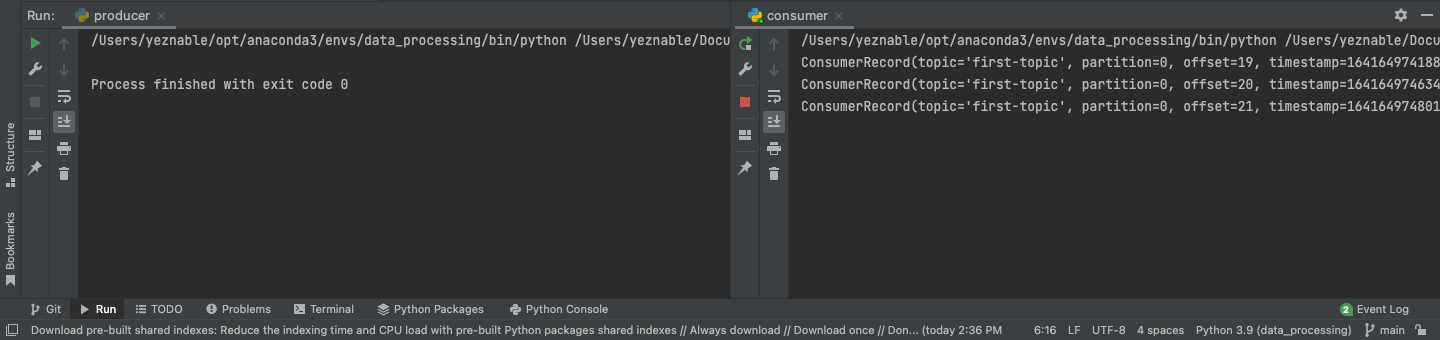

## Broker 분산 환경 시뮬레이션
여러개의 Broker를 관리하는 방법을 익히기 위해 Docker를 활용한다.  
https://docs.docker.com/get-docker/ 링크로 들어가 맞는 버전의 도커를 설치한다.

In [ ]:
# docker를 생성하기 위해 docker-compose.yml을 다음과 같이 작성한다.
version: '3'
services:
  zookeeper:
    image: zookeeper:3.7
    hostname: zookeeper
    ports:
      - "2181:2181"
    environment:
      ZOO_MY_ID: 1
      ZOO_PORT: 2181
      ZOO_SERVERS: server.1=zookeeper:2888:3888
    volumes:
      - ./data/zookeeper/data:/data
      - ./data/zookeeper/datalog:/datalogco

In [ ]:
# 다음 명령어를 실행하면 docker에 zookeeper환경이 다운로드 받아진다.
!cd Documents/GitHub/Data_Processing/Kafka
!docker-compose up